# Hyperbolic MDS Visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
import time
# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [2]:
def generate_data(n):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, 0.7, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    return init_data

In [3]:
from sklearn.metrics import euclidean_distances

def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

def conjugate(z):
    z_bar = np.array([z[0], -z[1]])
    return z_bar

def poincare_dist(u, v, eps=1e-3):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

def partial_d(theta, x, eps=1e-3):
    alpha = 1 - norm(theta)**2
    beta = 1 - norm(x)**2
    gamma = 1 + 2/(alpha*beta + eps) * norm(theta-x)**2
    lhs = 4 / (beta*np.sqrt(gamma**2 - 1) + eps)
    rhs = 1/(alpha**2 + eps) * (norm(x)**2 - 2*np.inner(theta,x) + 1) * theta - x/(alpha + eps)
    return lhs*rhs

In [4]:
def loss_fn(embed_config, dissimilarities, n, alpha=1):
    loss = 0
    for i in range(n):
        for j in range(i+1, n):
            zi_error = (poincare_dist(embed_config[i], embed_config[j]) - alpha*dissimilarities[i][j])**2
            loss += zi_error
    return loss

def proj(theta, eps=1e-2):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta

In [5]:
def step_error(r, Z, g, dissimilarities, n, eps=1e-3):
        M_r = np.zeros((n, 2))
        for j in range(n):
            M_r[j] = (-r*g[j] + Z[j]) / (-r*g[j] * conjugate(Z[j]) + 1 + eps)
            #print(M_r[j])
        return loss_fn(M_r, dissimilarities, n)

def line_search(Z, dissimilarities, g, n, r0, rmax):
    Z_norm = norm(Z, axis=1)**2
    M_prime = g*Z_norm.reshape(-1,1)
    qprime_0 = np.dot(M_prime[:,0].T, g[:,0]) + np.dot(M_prime[:,1].T, g[:,1])
    p = 0.5
    r = r0
    q0 = step_error(0, Z, g, dissimilarities, n)
    roof_fn = lambda r:q0 + p*qprime_0*r
    rmin = 1e-6
    while rmin < r < rmax and step_error(r, Z, g, dissimilarities, n) < roof_fn(r):
        #print(step_error(r, Z, g, dissimilarities, n))
        r = 2*r
    while r > rmax or step_error(r, Z, g, dissimilarities, n) > roof_fn(r):
        #print(step_error(r, Z, g, dissimilarities, n))
        if r < rmin:
            return 2*r
        r = r/2
    return r

In [6]:
from sklearn.decomposition import PCA
class HyperMDS():
    
    def __init__(self, dim=2, max_iter=3, verbose=0, eps=1e-5, alpha=1,
                 random_state=None, dissimilarity="euclidean"):
        self.dim = dim
        self.dissimilarity = dissimilarity
        self.max_iter = max_iter
        self.alpha = alpha
        self.eps = eps
        self.verbose = verbose
        self.random_state = random_state
        
    def init_embed(self, low=-0.5, high=0.5):
        rand_init = np.random.uniform(low, high, size=(self.n, self.dim))
        self.embedding = rand_init
    
    def loss_fn(self):
        loss = 0
        for i in range(self.n):
            for j in range(i+1, self.n):
                d_ij = poincare_dist(self.embedding[i], self.embedding[j])
                delta_ij = self.alpha*self.dissimilarity_matrix[i][j]
                loss += (d_ij - delta_ij)**2
        self.loss = loss

    def compute_gradients(self):
        gradients = np.zeros((self.n, 2))
        for i in range(self.n):
            grad_zi = 0
            for j in range(i+1, self.n):
                dd_ij = 2*poincare_dist(self.embedding[i], self.embedding[j])
                ddelta_ij = 2*self.alpha*self.dissimilarity_matrix[i][j]
                dd_loss = dd_ij - ddelta_ij
                dd_dist = partial_d(self.embedding[i], self.embedding[j])
                grad_zi += dd_loss * dd_dist
            gradients[i] = grad_zi
        self.gradients = gradients
    
    def fit(self, X, init=None):
        """
        Uses gradient descent to find the embedding configuration in the Poincaré disk
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        self.fit_transform(X, init=init)
        return self

    def fit_transform(self, X, init=None, max_epochs = 40, verbose=False):
        """
        Fit the embedding from X, and return the embedding coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        if self.dissimilarity == "precomputed":
            self.dissimilarity_matrix = X
        elif self.dissimilarity == "euclidean":
            self.dissimilarity_matrix = euclidean_distances(X)
        self.n = self.dissimilarity_matrix.shape[0]
        
        if init == 'pca':
            pca = PCA(n_components=2)
            X_proj = pca.fit_transform(X)
            X_proj = X_proj / norm(X_proj)
            self.embedding = X_proj
        else:
            self.init_embed()
        
        #error_tol =
        #min_grad = 
        #min_step = 
        smax = 0.1
        loss_time = 0
        grad_time = 0
        line_time = 0
        prev_loss = np.inf
        self.loss_fn()
        print('Inital loss: ', self.loss)
        for i in range(max_epochs):
            start = time.time()
            self.loss_fn()
            if np.abs(self.loss - prev_loss)/self.loss < 0.001:
                print('loss decrease not sufficient')
                break
            prev_loss = self.loss
            end = time.time()
            loss_time += end - start
            start = time.time()
            self.compute_gradients()
            end = time.time()
            grad_time += end - start
            rmax = 1/(np.linalg.norm(self.gradients, np.inf).max()+self.eps) * np.tanh(smax/2)
            start = time.time()
            r = line_search(self.embedding, self.dissimilarity_matrix, self.gradients,
                            self.n, 0.001, rmax)
            #print(r)
            end = time.time()
            line_time += end - start
            for j in range(self.n):
                zi_num = -r*self.gradients[j] + self.embedding[j]
                zi_denom = -r*self.gradients[j] * conjugate(self.embedding[j]) + 1
                zi_prime = zi_num / zi_denom
                self.embedding[j] = proj(zi_prime)
            if verbose:
                print('Epoch ' +str(i+1) + ' complete')
                print('Loss: ', self.loss)
        print('Final loss: ', self.loss)
        #print('Loss time: ', loss_time)
        #print('Gradient time: ', grad_time)
        #print('Line search time: ', line_time)
        return self.embedding

In [7]:
def pd_matrix(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

def sammon_stress(embedding, dissimilarity_matrix, alpha=1):
    stress = 0
    scale = 0
    n = embedding.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            d_ij = poincare_dist(embedding[i], embedding[j])
            delta_ij = alpha * dissimilarity_matrix[i][j]
            scale += delta_ij
            stress += (d_ij - delta_ij)**2 #/ delta_ij
    return stress/scale

In [8]:
data = generate_data(10)
hmds = HyperMDS()
emb = hmds.fit_transform(data, max_epochs=50)
print('Sammon Stress: ', sammon_stress(emb, hmds.dissimilarity_matrix))

Inital loss:  23.12875780445263
loss decrease not sufficient
Final loss:  0.9444289931746773
Sammon Stress:  0.024510665837042957


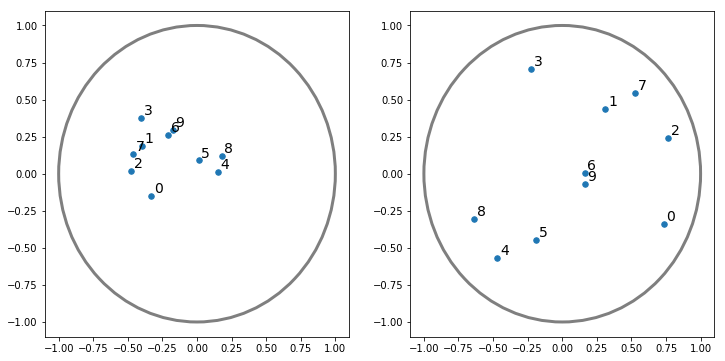

In [9]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

x = emb[:,0]
y = emb[:,1]
ax.scatter(x, y, s=30, alpha=1)
for i in range(len(emb)):
    ax.text(x[i]+0.02, y[i]+0.02, str(i), size=14)

ax2 = fig.add_subplot(122)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax2.add_patch(circ)

x = data[:,0]
y = data[:,1]
ax2.scatter(x, y, s=30, alpha=1)
for i in range(len(data)):
    ax2.text(x[i]+0.02, y[i]+0.02, str(i), size=14);
plt.show();

In [10]:
zoo = pd.read_csv('zoo.data', header=None)
animals = ['hare', 'goat', 'octopus', 'wolf', 'chicken', 'tuna', 'lobster', 'cheetah', 
           'dove', 'opossum', 'raccoon', 'crow', 'sparrow']
animals_data = zoo.loc[zoo[0].apply(lambda x: x in animals), ]
animals_data = zoo.loc[np.random.permutation(len(zoo))[:40]]
animals_name = animals_data[0]
animals_data = animals_data.loc[:, 1:]
animals_name = np.array(animals_name)

In [12]:
hmds = HyperMDS()
animals_emb = hmds.fit_transform(animals_data, max_epochs=20, verbose=True)
sammon_stress(animals_emb, hmds.dissimilarity_matrix)

Inital loss:  9756.32005916668
Epoch 1 complete
Loss:  9756.32005916668
Epoch 2 complete
Loss:  9569.725569142014
Epoch 3 complete
Loss:  9376.50503330245
Epoch 4 complete
Loss:  9176.6547761148
Epoch 5 complete
Loss:  8970.167292802056
Epoch 6 complete
Loss:  8757.130386242206
Epoch 7 complete
Loss:  8537.916093338816
Epoch 8 complete
Loss:  8313.4936926308
Epoch 9 complete
Loss:  8199.76651675351
Epoch 10 complete
Loss:  8085.951637002831
Epoch 11 complete
Loss:  7972.057492448984
Epoch 12 complete
Loss:  7857.427076882258
Epoch 13 complete
Loss:  7741.185185361912
Epoch 14 complete
Loss:  7622.969380146127
Epoch 15 complete
Loss:  7502.949804131363
Epoch 16 complete
Loss:  7381.546525541688
Epoch 17 complete
Loss:  7259.405045089872
Epoch 18 complete
Loss:  7137.4304774425855
Epoch 19 complete
Loss:  7016.368268752998
Epoch 20 complete
Loss:  6896.749473330699
Final loss:  6896.749473330699


2.076028837200581

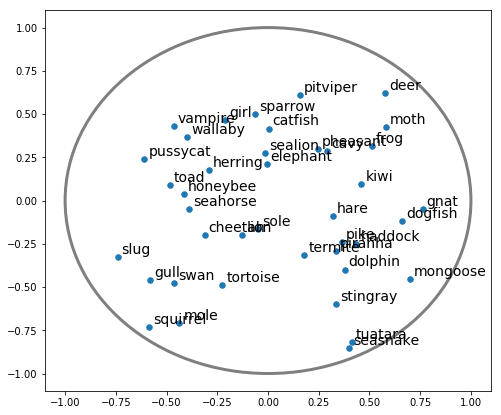

In [13]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

x = animals_emb[:,0]
y = animals_emb[:,1]
ax.scatter(x, y, s=30, alpha=1)
for i in range(len(animals_emb[:40])):
    ax.text(x[i]+0.02, y[i]+0.02, animals_name[i], size=14)
plt.show();

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
iris_data = iris.data

hmds = HyperMDS(alpha=1)
iris_emb = hmds.fit_transform(iris_data, max_epochs=30, init='pca', verbose=True)
sammon_stress(iris_emb, hmds.dissimilarity_matrix)

Inital loss:  87109.53059297153
Epoch 1 complete
Loss:  87109.53059297153
Epoch 2 complete
Loss:  85287.61083019283
Epoch 3 complete
Loss:  83490.2244889539
Epoch 4 complete
Loss:  81716.1826779419
Epoch 5 complete
Loss:  79964.10589937915
Epoch 6 complete
Loss:  78232.54509640229
Epoch 7 complete
Loss:  76520.03926846114
Epoch 8 complete
Loss:  74825.13713848217
Epoch 9 complete
Loss:  73146.41911837916
Epoch 10 complete
Loss:  71482.5082558219
Epoch 11 complete
Loss:  69832.09032318294
Epoch 12 complete
Loss:  68193.88970270974
Epoch 13 complete
Loss:  66566.67581716095
Epoch 14 complete
Loss:  64949.26656042743
Epoch 15 complete
Loss:  63340.528006560635
Epoch 16 complete
Loss:  61739.374050240294
Epoch 17 complete
Loss:  60144.76709327822
Epoch 18 complete
Loss:  58555.720642419714
Epoch 19 complete
Loss:  56971.304051590436
Epoch 20 complete
Loss:  55390.649435178864
Epoch 21 complete
Loss:  53812.96139710161
Epoch 22 complete
Loss:  52237.53067278858
Epoch 23 complete
Loss:  5066

1.3409079191710034

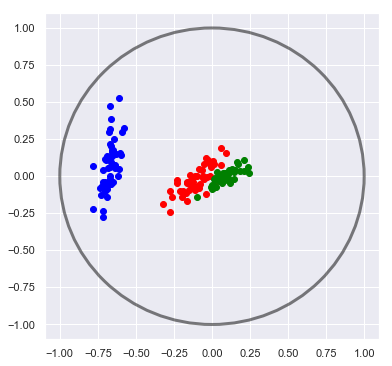

In [34]:
def plot_poincare(data, title=None):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
    ax.add_patch(circ)
    ax.scatter(data[:,0], data[:,1], s=20, alpha=1)
    if title != None: plt.title(title)
    plt.show()
y = iris.target
X = iris_emb
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
ax.scatter(X[(y==0), 0], X[(y==0), 1], c='blue')
ax.scatter(X[(y==1), 0], X[(y==1), 1], c='red');
ax.scatter(X[(y==2), 0], X[(y==2), 1], c='green');

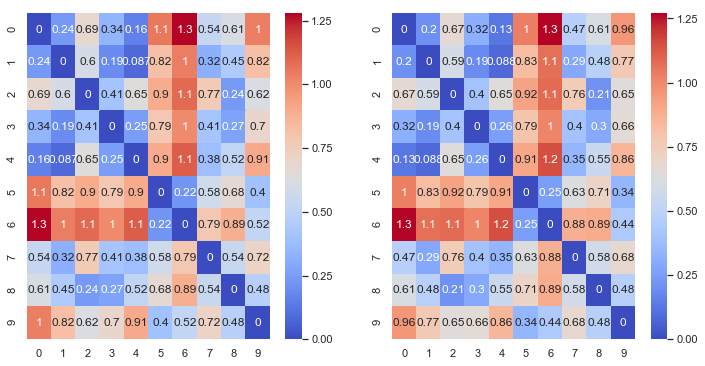

In [36]:
import seaborn as sns
n = data.shape[0]
delta1 = euclidean_distances(data)
delta2 = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        delta2[i][j] = poincare_dist(emb[i], emb[j])
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
sns.set()
sns.heatmap(delta1, cmap="coolwarm", annot=True);
ax = fig.add_subplot(122)
sns.heatmap(delta2, cmap="coolwarm", annot=True);

In [2]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()